# Unsupervised Sentiment Analysis - KMeans Sparse

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re

## Preprocessing the data

In [2]:
address = '.\IMDB_Dataset.csv'

In [3]:
imdb = pd.read_csv(address)

In [4]:
imdb.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data cleaning steps


In [5]:
def text_to_word_list(text):
    text = str(text)
    text = text.lower()
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()
    text = str(text)
    return text

In [6]:
# dropping NAN and duplicates from the data
imdb_trimmed = imdb.dropna().drop_duplicates().reset_index(drop=True)

In [7]:
#applying the text prep to the review column
imdb_trimmed.review = imdb_trimmed.review.apply(lambda x: text_to_word_list(x))

In [8]:
# creating label for sentiment for future evaluation
imdb_trimmed['sentiment'] = imdb_trimmed['sentiment'].map({'positive':1,'negative':0})
imdb_trimmed.head()

,review,sentiment
0,"['one', 'of', 'the', 'other', 'reviewers', 'ha...",1
1,"['a', 'wonderful', 'little', 'production', 'th...",1
2,"['i', 'thought', 'this', 'was', 'a', 'wonderfu...",1
3,"['basically', 'there', 'a', 'family', 'where',...",0
4,"['petter', 'mattei', 'love', 'in', 'the', 'tim...",1


## Modeling - Applying KMeans Clustering 

### Vectorizing, normalizing, and applying PCA to reduce the dimensionality

#### Extract features from text using bag of words - CountVectorizer

In [9]:
# Implementing KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
# vectorizng the texts
vectorizer = CountVectorizer(stop_words = 'english',max_features=20000)
vec = vectorizer.fit_transform(imdb_trimmed.review)

# normlaizing the vectorized vector
vec_norm = normalize(vec)
vec_arr = vec_norm.toarray()

#performing PCA to reduce dimensionality
vec_pca = PCA(n_components = 2)
vec_tranformed = vec_pca.fit_transform(vec_arr)

kmeans = KMeans(n_clusters=2, max_iter=1000, algorithm = 'auto')

fitted = kmeans.fit(vec_tranformed)
prediction = kmeans.predict(vec_tranformed)

In [12]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score

# evaluate the accuracy of the model
imdb_trimmed['sentiment_pred_vec'] = pd.Series(prediction)
f1 = f1_score(imdb_trimmed['sentiment'],imdb_trimmed['sentiment_pred_vec'],pos_label=1)
acc = accuracy_score(imdb_trimmed['sentiment'],imdb_trimmed['sentiment_pred_vec'])

print("F1 Score : {:.2f} and Accuracy {:.2f}".format(f1,acc))

F1 Score : 0.62 and Accuracy 0.55


In [13]:
# visualizing the sparse matrix
i = 10000
j = 10
words = vectorizer.get_feature_names()[i:i+10]
pd.DataFrame(vec[j:j+10,i:i+10].todense(), columns=words)

,killers,killian,killing,killings,killjoy,kills,kilmer,kilter,kim,kimberly
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [14]:
imdb_trimmed['sentiment_pred_vec'].value_counts()

1    32780
0    16802
Name: sentiment_pred_vec, dtype: int64

#### Extract features from text using bag of words - TfidfVectorizer

In [15]:
# applying the KMeans with tf-idf 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tf_idf = TfidfVectorizer(stop_words = 'english',max_features=20000)
vec_tf_idf = vectorizer_tf_idf.fit_transform(imdb_trimmed.review)

vec_norm_tf_idf = normalize(vec_tf_idf)
vec_arr_tf_idf = vec_norm_tf_idf.toarray()

vec_pca_tf_idf = PCA(n_components = 2)
vec_tranformed_tf_idf = vec_pca_tf_idf.fit_transform(vec_arr_tf_idf)

kmeans = KMeans(n_clusters=2, max_iter=1000, algorithm = 'auto')

fitted_tf_idf = kmeans.fit(vec_tranformed_tf_idf)
prediction_tf_idf = kmeans.predict(vec_tranformed_tf_idf)

In [16]:
imdb_trimmed['sentiment_pred_tf_idf'] = pd.Series(prediction_tf_idf)
f1 = f1_score(imdb_trimmed['sentiment'],imdb_trimmed['sentiment_pred_tf_idf'],pos_label=1)
acc = accuracy_score(imdb_trimmed['sentiment'],imdb_trimmed['sentiment_pred_tf_idf'])

print("F1 Score : {:.2f} and Accuracy {:.2f}".format(f1,acc))

F1 Score : 0.34 and Accuracy 0.45


## Optimizing parameters

### Testing combination of different models - 27 cases

In order to tune hyperparameters, created a function to apply changing parameters and resulting different models. Three parameters that can be changed are max_iter, max_features, min_df=1

In [14]:
def model_param_vec(max_iter=1000, max_features=None, min_df=1):
  vectorizer = CountVectorizer(max_features=max_features, min_df=min_df)
  features = vectorizer.fit_transform(imdb_trimmed.review)
  model = KMeans(n_clusters=2, max_iter=max_iter, algorithm = 'auto')
  model.fit(features)
  pred = model.predict(features)
  return pred, {
    "max_features": max_features,
    "min_df": min_df,
    "max_iter": max_iter,
    "auc": roc_auc_score(imdb_trimmed.sentiment, pred)
  }

In [31]:
from sklearn.metrics import roc_auc_score
def model_param_tf_id(max_iter=1000, max_features=None, min_df=1):
  vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
  features = vectorizer.fit_transform(imdb_trimmed.review)
  model = KMeans(n_clusters=2, max_iter=max_iter, algorithm = 'auto')
  model.fit(features)
  pred = model.predict(features)
  return {
    "max_features": max_features,
    "min_df": min_df,
    "max_iter": max_iter,
    "auc": roc_auc_score(imdb_trimmed.sentiment, pred),
    "acc": accuracy_score(imdb_trimmed.sentiment, pred)
  }

In [19]:
from itertools import product
params = {
  "max_features": [10000, 50000, None],
  "min_df": [1,2,3],
  "max_iter": [1000, 2000, 3000]
}

In [20]:
results_vec = []
for p in product(*params.values()):
  res = model_param_vec(**dict(zip(params.keys(), p)))
  results_vec.append( res )
  print (res)


{'max_features': 10000, 'min_df': 1, 'max_iter': 1000, 'auc': 0.4903883259558459}
{'max_features': 10000, 'min_df': 1, 'max_iter': 2000, 'auc': 0.5096116740441541}
{'max_features': 10000, 'min_df': 1, 'max_iter': 3000, 'auc': 0.5096116740441541}
{'max_features': 10000, 'min_df': 2, 'max_iter': 1000, 'auc': 0.5096116740441541}
{'max_features': 10000, 'min_df': 2, 'max_iter': 2000, 'auc': 0.5096116740441541}
{'max_features': 10000, 'min_df': 2, 'max_iter': 3000, 'auc': 0.5096116740441541}
{'max_features': 10000, 'min_df': 3, 'max_iter': 1000, 'auc': 0.5096116740441541}
{'max_features': 10000, 'min_df': 3, 'max_iter': 2000, 'auc': 0.4903883259558459}
{'max_features': 10000, 'min_df': 3, 'max_iter': 3000, 'auc': 0.5096116740441541}
{'max_features': 50000, 'min_df': 1, 'max_iter': 1000, 'auc': 0.5096116740441541}
{'max_features': 50000, 'min_df': 1, 'max_iter': 2000, 'auc': 0.5096116740441541}
{'max_features': 50000, 'min_df': 1, 'max_iter': 3000, 'auc': 0.5096116740441541}
{'max_features':

In [21]:
results_tf_id = []
for p in product(*params.values()):
  res = model_param_tf_id(**dict(zip(params.keys(), p)))
  results_tf_id.append( res )
  print (res)

{'max_features': 10000, 'min_df': 1, 'max_iter': 1000, 'auc': 0.49531398447725294}
{'max_features': 10000, 'min_df': 1, 'max_iter': 2000, 'auc': 0.5046860155227471}
{'max_features': 10000, 'min_df': 1, 'max_iter': 3000, 'auc': 0.49515081747060835}
{'max_features': 10000, 'min_df': 2, 'max_iter': 1000, 'auc': 0.5025183350055945}
{'max_features': 10000, 'min_df': 2, 'max_iter': 2000, 'auc': 0.5043395882768587}
{'max_features': 10000, 'min_df': 2, 'max_iter': 3000, 'auc': 0.5025184863272101}
{'max_features': 10000, 'min_df': 3, 'max_iter': 1000, 'auc': 0.5034278267291091}
{'max_features': 10000, 'min_df': 3, 'max_iter': 2000, 'auc': 0.5035899344844441}
{'max_features': 10000, 'min_df': 3, 'max_iter': 3000, 'auc': 0.5045645481974576}
{'max_features': 50000, 'min_df': 1, 'max_iter': 1000, 'auc': 0.4569050096879027}
{'max_features': 50000, 'min_df': 1, 'max_iter': 2000, 'auc': 0.4573154671296974}
{'max_features': 50000, 'min_df': 1, 'max_iter': 3000, 'auc': 0.4587581267355044}
{'max_features

### Performing TfidfVectorizer - NO PCA - Optimized parameters of max_features=None and min_df=2

In [32]:
from itertools import product
params = {
  "max_features": [None],
  "min_df": [2],
  "max_iter": [1000]
}
results_tf_id = []
for p in product(*params.values()):
  res = model_param_tf_id(**dict(zip(params.keys(), p)))
  results_tf_id.append( res )
  print (res)

{'max_features': None, 'min_df': 2, 'max_iter': 1000, 'auc': 0.5428380152935453, 'acc': 0.542999475616151}


In [13]:
# applying the KMeans with tf-idf _ not performing PCA 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tf_idf = TfidfVectorizer(stop_words = 'english',max_features=None, min_df=2)
vec_tf_idf = vectorizer_tf_idf.fit_transform(imdb_trimmed.review)

kmeans = KMeans(n_clusters=2, max_iter=1000, algorithm = 'auto')

fitted_tf_idf = kmeans.fit(vec_tf_idf)
prediction_tf_idf = kmeans.predict(vec_tf_idf)

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score

imdb_trimmed['sentiment_pred_tf_idf'] = pd.Series(prediction_tf_idf)
f1 = f1_score(imdb_trimmed['sentiment'],imdb_trimmed['sentiment_pred_tf_idf'],pos_label=1)
acc = accuracy_score(imdb_trimmed['sentiment'],imdb_trimmed['sentiment_pred_tf_idf'])

print("F1 Score : {:.2f} and Accuracy {:.2f}".format(f1,acc))

F1 Score : 0.65 and Accuracy 0.57


### Visulizing the results of TfidfVectorizer with optimal parameters

In [18]:
vec_arr_tf_idf = vec_tf_idf.toarray()

In [19]:
def top_cluster(vec_arr, prediction, number_features):
    labels = np.unique(prediction)
    data = []
    for label in labels:
        idx = np.where(prediction==label)
        xmeans = np.mean(vec_arr[idx], axis = 0)
        meanavg = np.argsort(xmeans)[::-1][:number_features]
        features = vectorizer_tf_idf.get_feature_names()
        best_features = [(features[i], xmeans[i]) for i in meanavg]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        data.append(df)
    return data
words = top_cluster(vec_arr_tf_idf, prediction_tf_idf, 10)

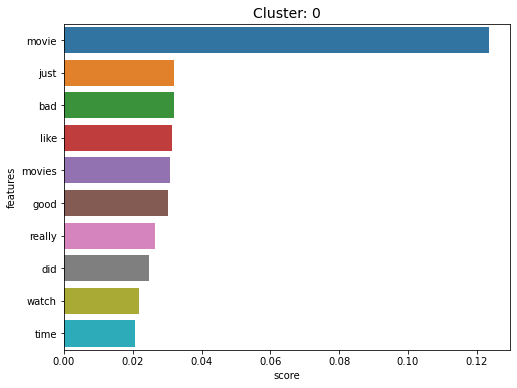

In [20]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = words[0][:15]);
plt.title("Cluster: "+ str(0), fontsize = 14);

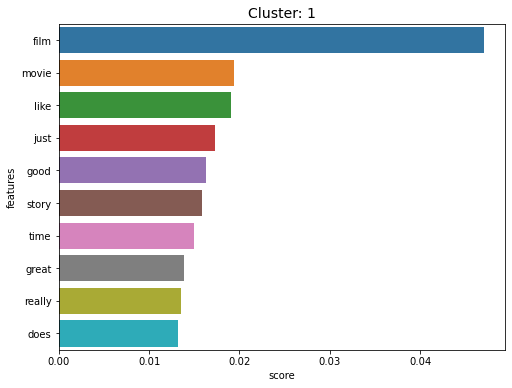

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = words[1][:15]);
plt.title("Cluster: "+ str(1), fontsize = 14);